#parser:

In [1]:
import inspect
import copy  
from collections import defaultdict
from IPython.display import Image
from util import *
from DataStructure import *

In [2]:
%run tokenizer.ipynb
%run others.ipynb
%xmode Plain
%pdb on
%matplotlib inline

Exception reporting mode: Plain
Automatic pdb calling has been turned ON


In [3]:
class SSA_live():
    def __init__(self):
        self._coalescing_pairs=[]
        pass
    def _update_live(self,G_reverse1):
        for i in self.loop_head:#parent[0] is inside the loop
            While_child=nx.descendants(G_reverse1,i[1])
            While_child.update([i[1]])
            for j in While_child:
                self.node[j]["live_in"].update(self.node[i[0]]["live_out_right"])

    def _init_live_left_right(self,node):
        if_bb,loop_bb=False,False
        live_left,live_right=set(),set()
        live=set(self.node[node]["live_in"])
        
        if node in [i[0] for i in self.if_head]:                    
            if_bb,live_left,live_right=True,set(live),set(live);print("if_BB detected!",node)   
        if node in [i[0] for i in self.loop_head]:                    
            loop_bb,live_left,live_right=True,set(live),set(live);print("loop_BB detected!",node)  
        return if_bb,loop_bb,live,live_left,live_right
    
    def _propagte_live_others(self,G_reverse,node,live,live_left,live_right,if_bb,loop_bb):
        #### update live? 
        #TODO: how can I remove 'live'?
        self.node[node]["live_out"]=set(live)
        #### propagate live to the mother and others bb
        if if_bb==True:
            f=[i for i in self.if_head if i[0]==node][0]
            self.node[node]["live_out_left"]=set(live_left)
            self.node[node]["live_out_right"]=set(live_right)
            #self.if_head= [(merge_bb,newbbif,mother_bb) | (merge_bb,newbbif,newbbelse)]
            self.node[f[1]]["live_in"].update(live_left)
            self.node[f[2]]["live_in"].update(live_right)

        elif loop_bb==True:
            f=[i for i in self.loop_head if i[0]==node][0]
            self.node[node]["live_out_left"]=set(live_left)
            # self.node[node]["live_out_right"] will be used in propagating the live to While childs later
            self.node[node]["live_out_right"]=set(live_right)
            #self.loop_head= [(join_node,inside_while_bb,join_mother)]
            self.node[f[2]]["live_in"].update(live_left)
        else:
            for i in G_reverse.successors(node):
                self.node[i]["live_in"].update(self.node[node]["live_out"])
                
    def _add_SSA_number_all(self,if_bb,loop_bb,if_phi,loop_phi,inst,live,live_left,live_right):            
        if if_phi: split_live(live_left,live_right,inst)
        elif loop_phi: split_live(live_left,live_right,inst)
        else:add_to_both(live,live,inst)

        if if_bb and not if_phi: add_to_both(live_left,live_right,inst)
        if loop_bb and not loop_phi: add_to_both(live_left,live_right,inst)  
        
        #there is no Phi is this type of BB
        #if not if_bb and not loop_bb: self._add_to_both(live,live,inst)
    
#https://stackoverflow.com/questions/17483022/coalesce-2-nodes-in-a-networkx-graph
    def _coalesce(self,G,node1,node2):
        if not G.has_node(node1):return G
        if not G.has_node(node2):return G   
        newedge = []
        for i in range(len(list(G.neighbors(node2)))):
            try:
                newedge.append((node1 , list(G.neighbors(node2))[i]))
            except:
                pass
        G.add_edges_from(newedge)

        try:a=G.nodes[node1]['labels']
        except:print("WTFFFFFF")
        try:aa=G.nodes[node2]['labels']
        except:print("WTFFFFFF")
        
        G.nodes[node1]['labels']=a+","+aa
        #print("coal label",G.nodes[node1]['labels'])
        G.remove_node(node2)        
        return G

    
    def _generate_interference_graph(self,live,inst):
        for to_node in live:
            self.graph_inf.add_edges_from([(to_node,inst.SSA_number)])    
            
    def _process_live_single_bb(self,node,if_bb,loop_bb,live,live_left,live_right,second_pass):
        for inst in reversed(self.node[node]["code"]):
            if_phi,loop_phi= if_bb and inst.op=="Phi",loop_bb and inst.op=="Phi"

            ###what to do in the case of CSE optimization?
            if node!=self.number and inst.op not in ["CMP"] and inst.SSA_number not in live: continue #dead code elimination
            if inst.op in ["None","BRA"] or "CSE" in inst.op: continue
            

            ###just for test
            try:xx=int(inst.x[1:-1])
            except:pass
            try:yy=int(inst.y[1:-1])
            except:pass
            
            #if inst.op=="Phi" and not self.graph_inf.has_edge(xx, yy): print(inst.x,inst.y,"not have connection!")
            if inst.op=="Phi" and not self.graph_inf.has_edge(xx, yy): self._coalescing_pairs.append((xx,yy,inst.SSA_number))
                
            #if if_bb:print("hoooooy",sorted(live),sorted(live_left),sorted(live_right),inst)
            ########## generate interference Graph: has to do after the post processing: add edge to graph
            if second_pass: self._generate_interference_graph(live,inst)

            ########## remove current inst from the all live sets
            remove_SSA_number_all(inst.SSA_number,live,live_left,live_right)

            ########## add operand of inst to the live set
            self._add_SSA_number_all(if_bb,loop_bb,if_phi,loop_phi,inst,live,live_left,live_right)            

        return live,live_left,live_right
    
    def _processing_inference_graph(self,G_reverse,second_pass=False):
        #G_reverse does not have a loops!        
        while len(G_reverse)>0:
            zero_entry=[node for node in G_reverse if G_reverse.in_degree(node)==0]
            
            while len(zero_entry)>0:
                node=zero_entry.pop()
                #print(node,"is pre processing!")
                
                # init the live sets, and detect if it is loop or if joint bb
                if_bb,loop_bb,live,live_left,live_right=self._init_live_left_right(node)
                
                ### process the live of a BB (node), and generate Intereference Graph if it is second pass
                live,live_left,live_right=self._process_live_single_bb(node,\
                                            if_bb,loop_bb,live,live_left,live_right,second_pass)                
                
                #### propagate live to node, the mother, and others bb
                self._propagte_live_others(G_reverse,node,live,live_left,live_right,if_bb,loop_bb)
                    
                G_reverse.remove_node(node)                        

In [4]:
class parser(SSA,Reg,parser_util,BB,SSA_code,Random_variable_gen,SSA_live):
    def __init__(self,tokens,rules):
        self.tokens=collections.deque([i for i in tokens if i.type!='COMMENT'])
        SSA.__init__(self)
        #Reg.__init__(self)
        parser_util.__init__(self)
        BB.__init__(self)   
        self.Random_variable=Random_variable_gen()
        self.loop_head=[]
        self.if_head=[]
        SSA_live.__init__(self)
    
                
    def make_inference_graph(self):
        #https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.cycles.find_cycle.html
        import matplotlib.pyplot as plt
        self.graph_inf=nx.Graph()
        
        #build graph
        G_reverse=self.G.reverse(copy=True)        
        G_reverse=self._remove_loops(G_reverse)
        
        # fisrt pass of processing
        self._processing_inference_graph(copy.deepcopy(G_reverse))
        G_vis=self.visulize_live("1",G=None)        
        
        # propagate live to children(for While)
        self._update_live(G_reverse.reverse(copy=True))
        G_vis=self.visulize_live("2",G=G_vis)
        
        # second pass of processing, and generating the interference graph. 
        self._processing_inference_graph(copy.deepcopy(G_reverse),second_pass=True)
        G_vis=self.visulize_live("3",G=G_vis)    
        
        for i in self.graph_inf.nodes():
            self.graph_inf.nodes[i]["labels"]=Parenthesize(i)
                
        for i in self._coalescing_pairs:
            self.graph_inf=self._coalesce(self.graph_inf,i[0],i[1])
            self.graph_inf=self._coalesce(self.graph_inf,i[0],i[2])
        
    def _convert_SSAinst_to_Reginst(self,inst,colors):
        xx=self._find(inst.x,colors)
        yy=self._find(inst.y,colors)
    
        zz=self._find(Parenthesize(inst.SSA_number),colors)
        
        if inst.op in ["CSE",None,"None"]: op=xx=yy=""
        #if inst.op in ["Phi"]:continue
        if inst.op in [None,"None"]: op=xx=yy=""
        else:op=inst.op

        if op=="Phi" and xx!=yy:
            op="MOVE"
                
        if op=="Phi" and xx==yy:yy+=" SAME";op=xx=yy=""
            
        zz=str(inst.SSA_number)+zz
        #return SSA_code(SSA_number=inst.SSA_number,op=op,x=xx,y=yy)        
        return SSA_code(SSA_number=zz,op=op,x=xx,y=yy)        
        
    def generate_reg_allocated_code(self):    
        colors=self.color_inf_graph()
        for k,v in self.node.items():
            for inst in self.node[k]["code"]:
                self.node[k]["code_reg_alloc"].append(self._convert_SSAinst_to_Reginst(inst,colors))
                    
    def _find(self,x,colors):
        return "R"+str(colors[x]) if x in colors.keys() else x

    def color_inf_graph(self):        
        nx.draw(self.graph_inf,with_labels=True,pos=nx.spring_layout(self.graph_inf))  
        a=nx.greedy_color(self.graph_inf)
        result=defaultdict(str)
        for k,v in a.items():
            kk=self.graph_inf.node[k]["labels"]
            for v_splited in kk.split(","):
                if v_splited=="" or v_splited==None: continue
                if v_splited in result.keys(): print("double register in colors!");#error
                result[v_splited]=v
        print(max([v for k,v in a.items()]),a)   
        
        print("colors=",result,a,self.graph_inf.nodes())
        return result

0 1 2 3 0 1 2 3 4 2 3 5 0 1 0 0 2 3 2 2 3 0 3 0 [(3, 4, 'forward'), (4, 3, 'forward')]
no loop found!
(3, 'blt', '(17)')
0 0 2 3 3 0 0 3 4 [(3, 4, 'forward'), (4, 3, 'forward')]
[(7, 8, 'forward'), (8, 7, 'forward')]
no loop found!
(7, 'blt', '(27)')
(1, 'blt', '(20)')
0 0 1 3 (4, 4, (13) ADD (10),#3, (14) ADD (10),#3, 'are the sameeeee: CSE')
[(3, 4, 'forward'), (4, 3, 'forward')]
[(7, 8, 'forward'), (8, 7, 'forward')]
no loop found!
('if_BB detected!', 10)
('loop_BB detected!', 7)
('loop_BB detected!', 3)
('if_BB detected!', 10)
('loop_BB detected!', 7)
('loop_BB detected!', 3)
(5, {3: 4, 4: 1, 6: 0, 7: 2, 9: 5, 10: 4, 11: 2, 12: 2, 15: 3, 35: 1, 20: 4, 21: 5, 23: 4, -1: 3})
('colors=', defaultdict(<type 'str'>, {'(7)': 2, '(3)': 4, '(35)': 1, '(24)': 4, '(26)': 0, '(12)': 2, '(31)': 3, '(21)': 5, '(15)': 3, '(9)': 5, '(23)': 4, '(-1)': 3, '(25)': 4, '(6)': 0, '(4)': 1, '(11)': 2, '(32)': 0, '(13)': 0, '(30)': 4, '(20)': 4, '(22)': 0, '(16)': 0, '(10)': 4, '(8)': 3}), {3: 4, 4: 1, 6:

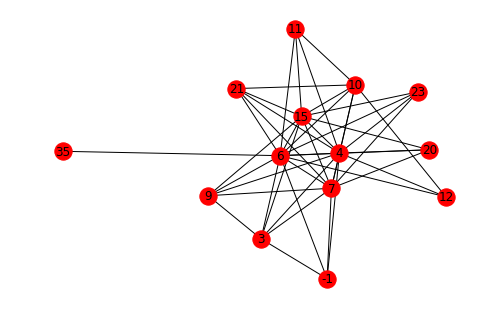

In [5]:
code='''
main
var a, b, c, d;
{
	let a <- 1 + 5 + 6;
	let b <- 2;
	let c <- 3;
	let d <- 4;
    let k <- 4;
    let c <- d+e;
    
	if a< b then
		let a <- a + 1;
		while c < d do
			let c <- c + 2;
			let d <- a + 3;
            let d <- a + 3 
		od
	else
		let a <- a + 4;
		while c < d do
			let d <- a + 5;
			let a <- d + 6 + k
		od
	fi;
    
	let a <- a + b + d
}.'''
#file_name="/home/ahmad/Documents/compiler/project/testprogs/test014.txt"
#code="".join([lines for lines in open(file_name,'r')])
    
def testa(code):
    tk=Tokenizer(l_kewords,token_specification)
    tk.tokenize_program(code)
    #tk.print_tokens()
    c=parser(tk.result,rules) 
    c.check_computation()    
    #c.visulize()

    # these lines are for CSE: need to be refactorized!
    c.build_graph()
    c.Remove_CSE()
    c.visulize()
    !graph-easy grid.dot --as_dot | dot -Tpng -o graph_after_cse.png
        
    #reg allocation:
    c.make_inference_graph()
    #c.color_inf_graph()#called inside generate_reg_allocated_code func. absord!
    
    #generate the register allocated code!
    c.generate_reg_allocated_code()
    c.visulize(show="code_reg_alloc")    
    !graph-easy grid.dot --as_dot | dot -Tpng -o graph_register.png
    
    !graph-easy grid_live.dot --as_dot | dot -Tpng -o graph_live.png
    
testa(code)
#Image(filename='graph.png') 

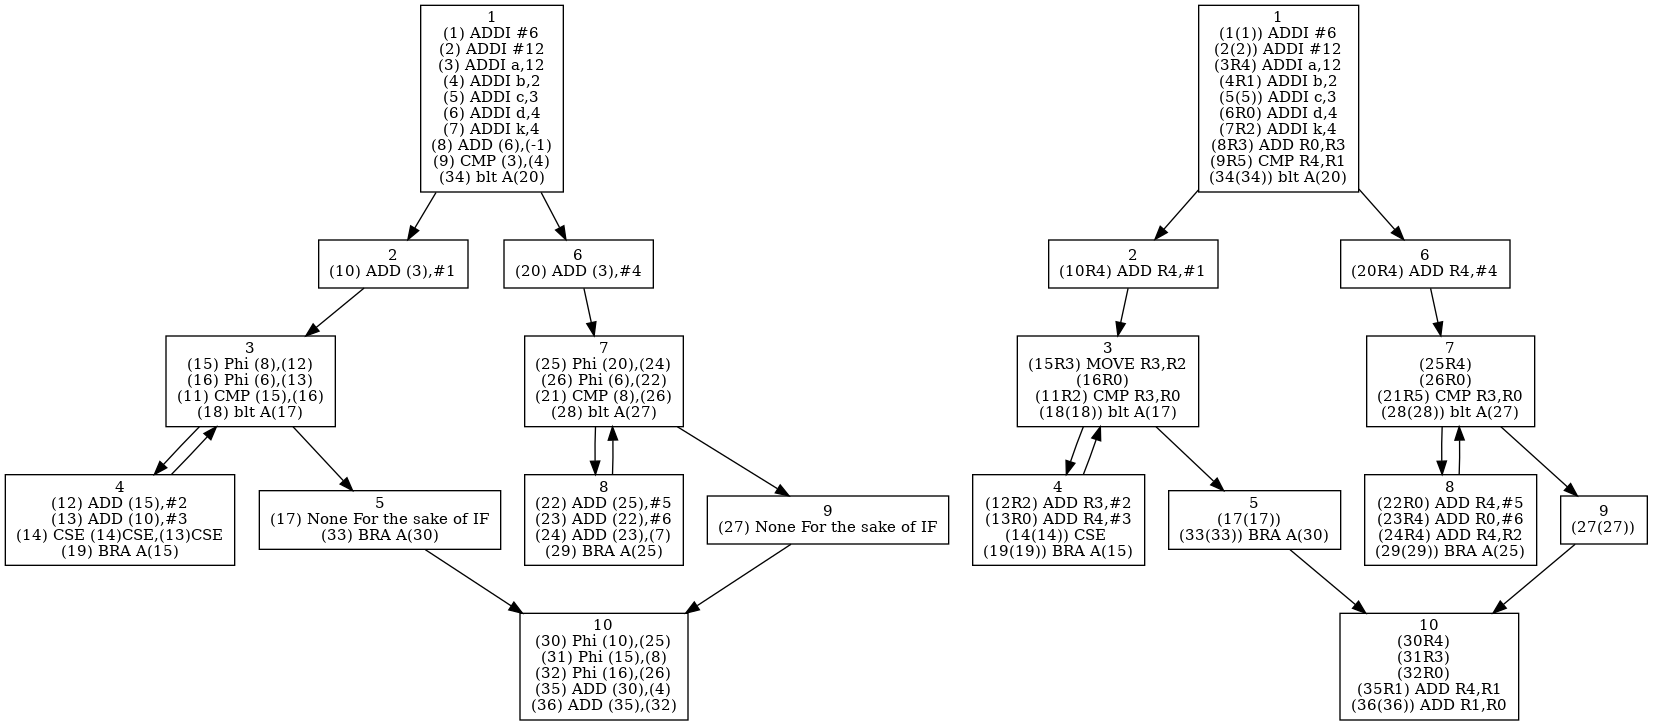

In [6]:
Image(filename='graph_register.png') 

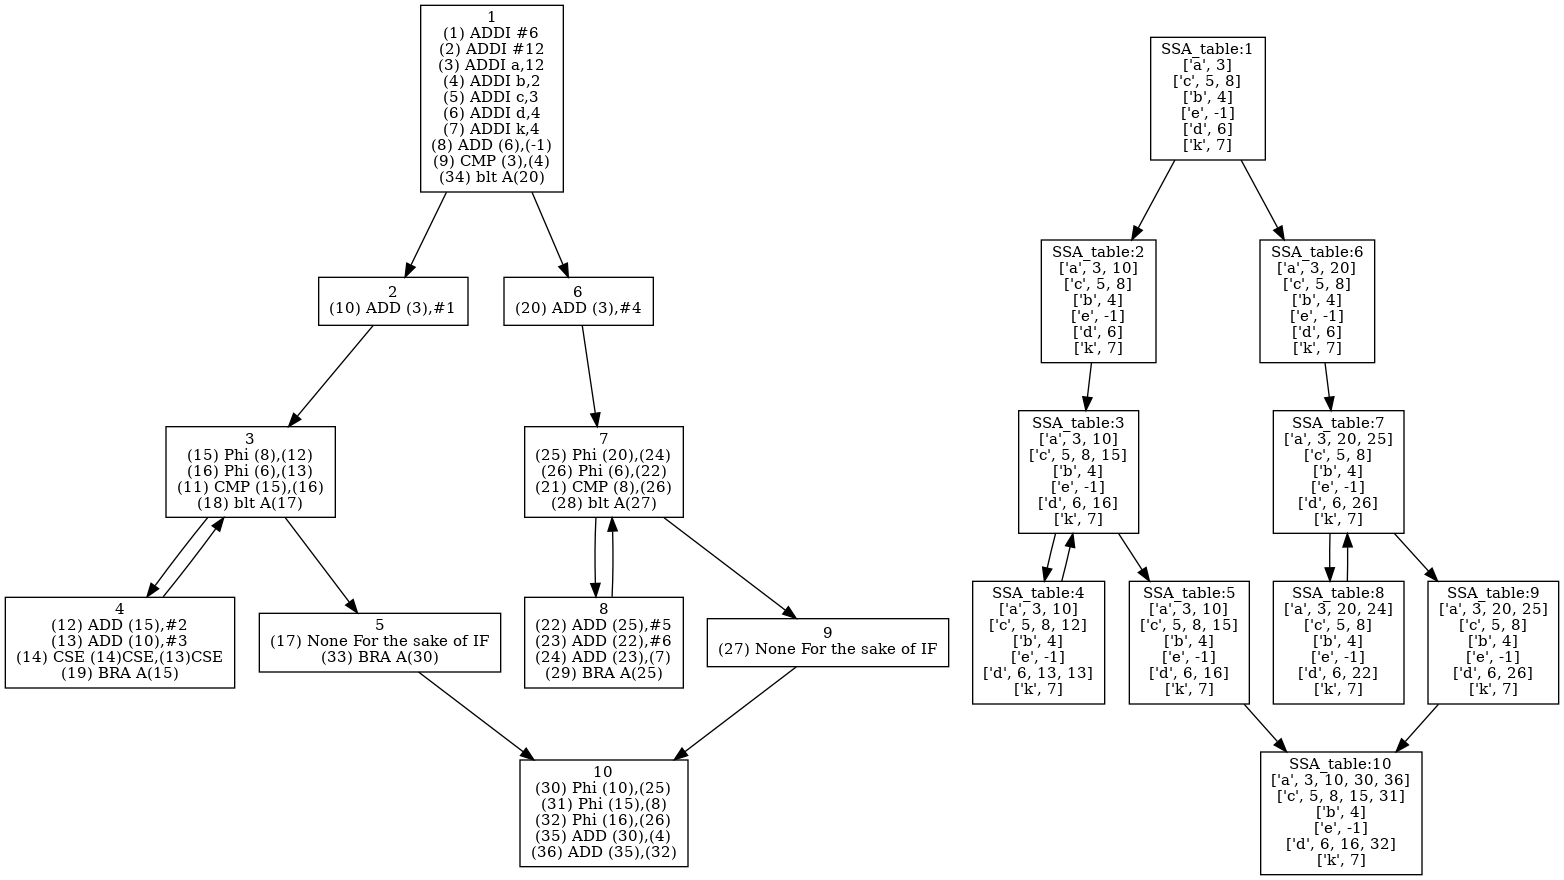

In [7]:
Image(filename='graph_after_cse.png')

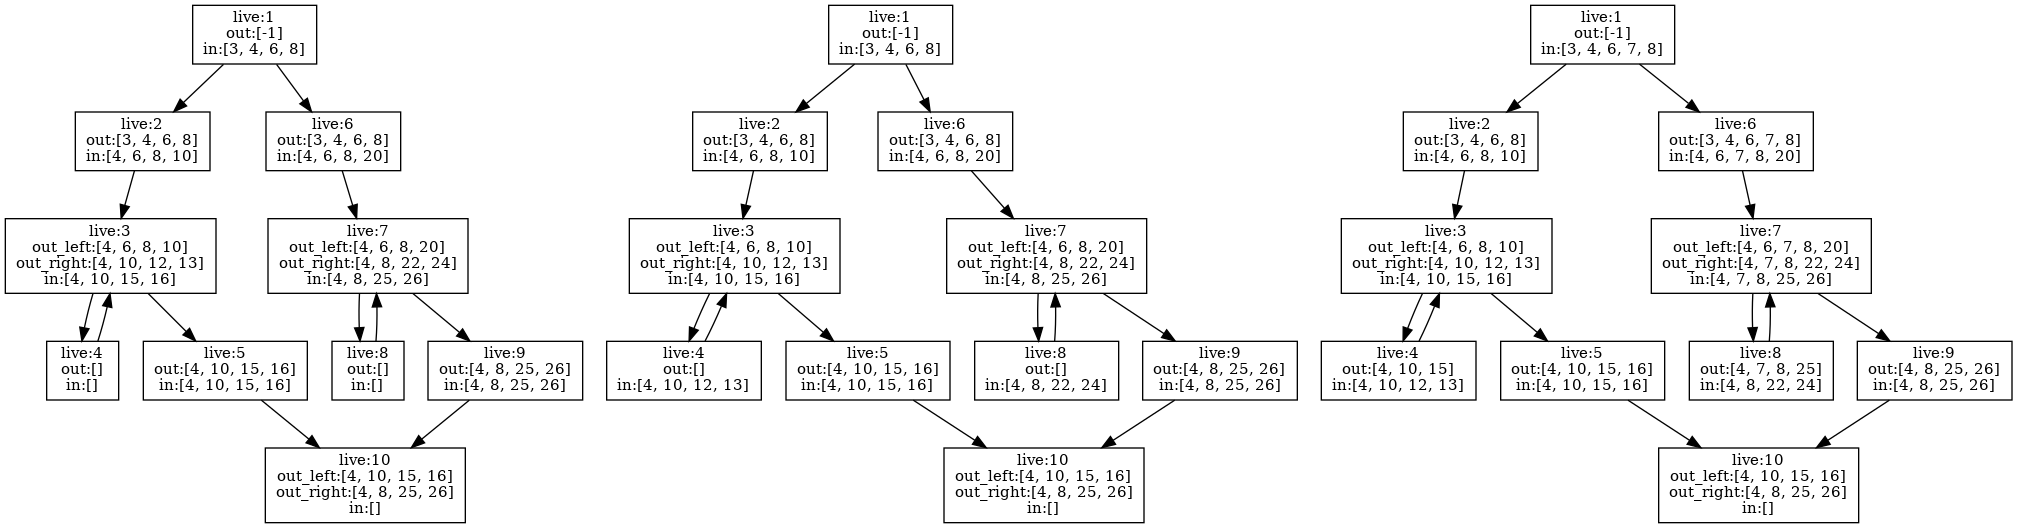

In [8]:
Image(filename='graph_live.png')

In [9]:
# to do: 
#ok: deal with a<- a+b+c+d+a * b*c*d
#deal with a<- 1:
    #Addi for now!
#ok: complete the while SSA generator
    # need to refactorize the code!
    # need to check: if it works for nested while and if: not now! the bb number is wrong for now(return path)!
    # check for nested if/while almost correct! need to check more
#remove redundant computations: a<-x+y  b<-x+y
#make 'live' graph of the SSA variables
#deal with arrays
#deal with functions/procedures: 
    #function BB: ok, 
    #call
    #return value
#deal with reserved functions: write, read,...
#deal with uninitilized variables
#maybe the list of SSA_table is wrong when I merge them in joint/merge bbs. 
    #it depends on how I use it for the later step(make 'live' graph of the SSA variables)